### XENONnT posterior analysis

In [51]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
from matplotlib import rc

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

XENONnT = np.load("chains/mcmc3_chain_100000.npz")
chain1 = XENONnT["chain"]         # shape = (nsteps, nwalkers, ndim)
log_prob1 = XENONnT["log_prob"]   # shape = (nsteps, nwalkers)
nsteps1, nwalkers1, ndim1 = chain1.shape

print("nsteps, nwalkers, ndim = ", np.shape(chain1))

try:
    tau = emcee.autocorr.integrated_time(chain1, tol=0)
    print("Autocorrelation time τ for each parameter:\n", tau)
    
    burnin = int(2 * np.max(tau))  # it's often burn-in 2*tau
    thinning = int(0.5 * np.min(tau))  
    # print(f"Suggested burn-in: {burnin}")
    
except emcee.autocorr.AutocorrError:
    print("Autocorrelation time could not be reliably estimated. Run longer.")
    burnin = 0
    thinning = 1

nsteps, nwalkers, ndim =  (100000, 15, 5)
Autocorrelation time τ for each parameter:
 [221.71445733 256.21017793 400.29742519 283.99143524 263.43504041]


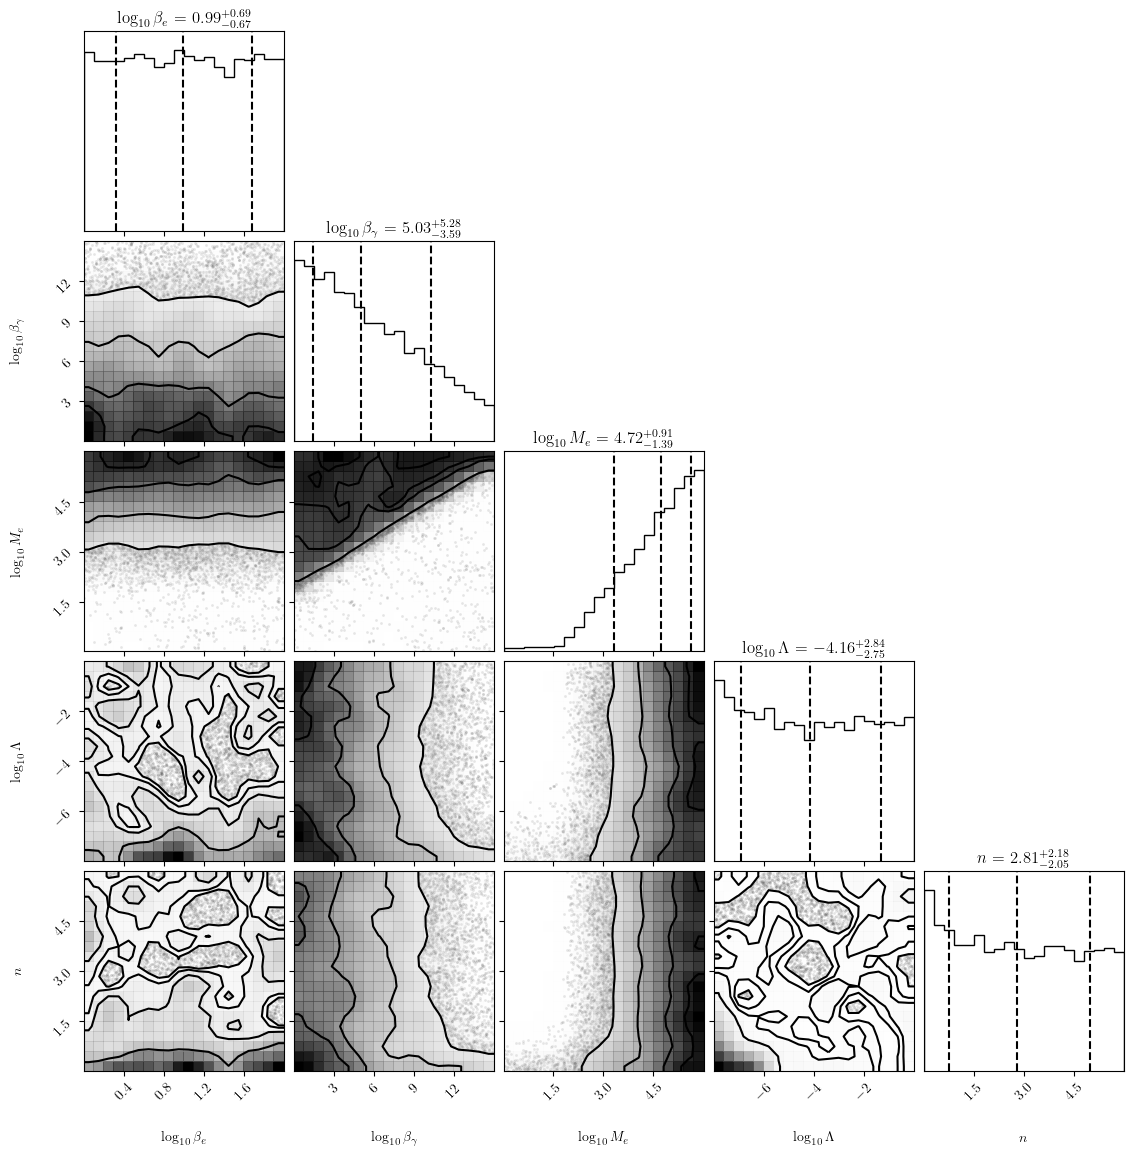

In [52]:
param_labels = ['ge', 'gg', 'logMe', 'gc', 'n']
latex_labels = [r'$\log_{10} \beta_e$', r'$\log_{10} \beta_\gamma$', r'$\log_{10} M_e$', r'$\log_{10} \Lambda$', r'$n$']

samples1 = chain1[burnin::thinning, :, :].reshape(-1, ndim1)
log_probs1 = log_prob1[burnin::thinning, :].reshape(-1)

figure = corner.corner(samples1, labels=latex_labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, smooth=True, title_kwargs={"fontsize": 12})
plt.show()

P/Pmax occurs near: -8.2365
Corresponding gg = 0.4077, logMe = 2.1610


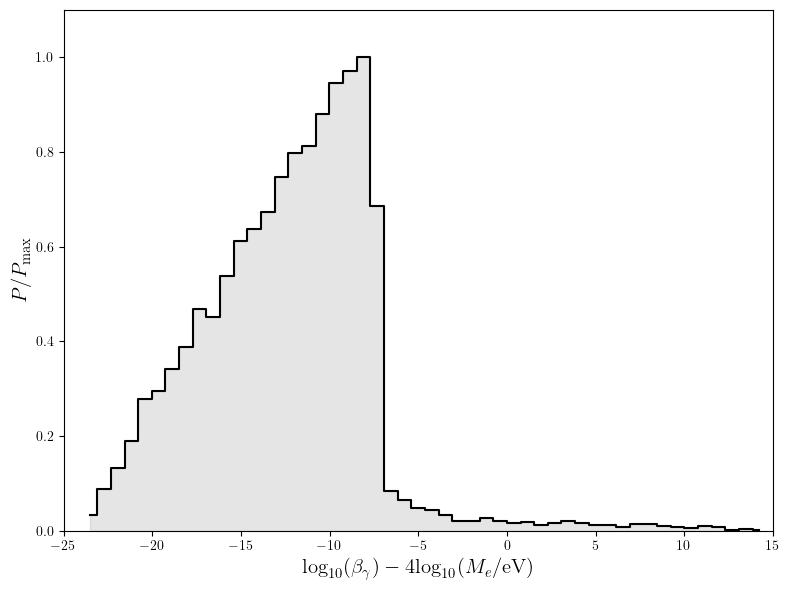

In [56]:
# Compute derived parameter
gg = samples1[:, param_labels.index("gg")]
logMe = samples1[:, param_labels.index("logMe")]
derived = gg - 4 * logMe

# Manually compute histogram
counts, bin_edges = np.histogram(derived, bins=50, density=False)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
normalized_counts = counts / np.max(counts)

max_bin_idx = np.argmax(counts)   # Find the bin with max P
bin_lo, bin_hi = bin_edges[max_bin_idx], bin_edges[max_bin_idx+1]
in_bin = (derived >= bin_lo) & (derived < bin_hi)   # Find samples in that bin

# Choose one of the samples (e.g. the first)
gg_peak = gg[in_bin][0]
logMe_peak = logMe[in_bin][0]
derived_peak = derived[in_bin][0]
print(f"P/Pmax occurs near: {derived_peak:.4f}")
print(f"Corresponding gg = {gg_peak:.4f}, logMe = {logMe_peak:.4f}")

plt.figure(figsize=(8,6))
# plt.hist(derived, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='k')
plt.plot(bin_centers, normalized_counts, drawstyle='steps-mid', color='black')
plt.fill_between(bin_centers, normalized_counts, step='mid', alpha=0.2, color='gray')

# q16, q50, q84 = np.percentile(derived, [16, 50, 84])
# plt.axvline(q50, color='r', linestyle='-', label=f"Median = {q50:.2f}")
# plt.axvline(q16, color='r', linestyle='--', label=r"$1\sigma$")
# plt.axvline(q84, color='r', linestyle='--')

plt.xlim(-25, 15)
plt.ylim(0.0, 1.1)
plt.xlabel(r"$ {\rm log}_{10}(\beta_{\gamma}) - 4{\rm log}_{10} ({M_e/ {\rm eV}})$", fontsize=15)
plt.ylabel(r"$P / P_{\max}$", fontsize=15)
# plt.title(r"${\rm XENONnT~Posterior~Density}$", fontsize=15)
# plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("plots/beta_eff.pdf")
plt.show()

### 95% parameters limits

In [59]:
# for i, label in enumerate(param_labels):
#     param_vals = samples1[:, i]
#     upper = np.percentile(param_vals, 95)
#     print(f"95% upper limit on {label}: {upper:.4f}")
    
#     plt.hist(param_vals, bins=50, density=True, alpha=0.6)
#     plt.axvline(upper, color='r', linestyle='--', label="95\% upper limit")
#     plt.xlabel(label, fontsize=15)
#     plt.ylabel("Posterior", fontsize=15)
#     plt.legend(fontsize=15)
#     plt.title(f"Posterior of {label}", fontsize=15)
#     plt.show()

Removed no burn in


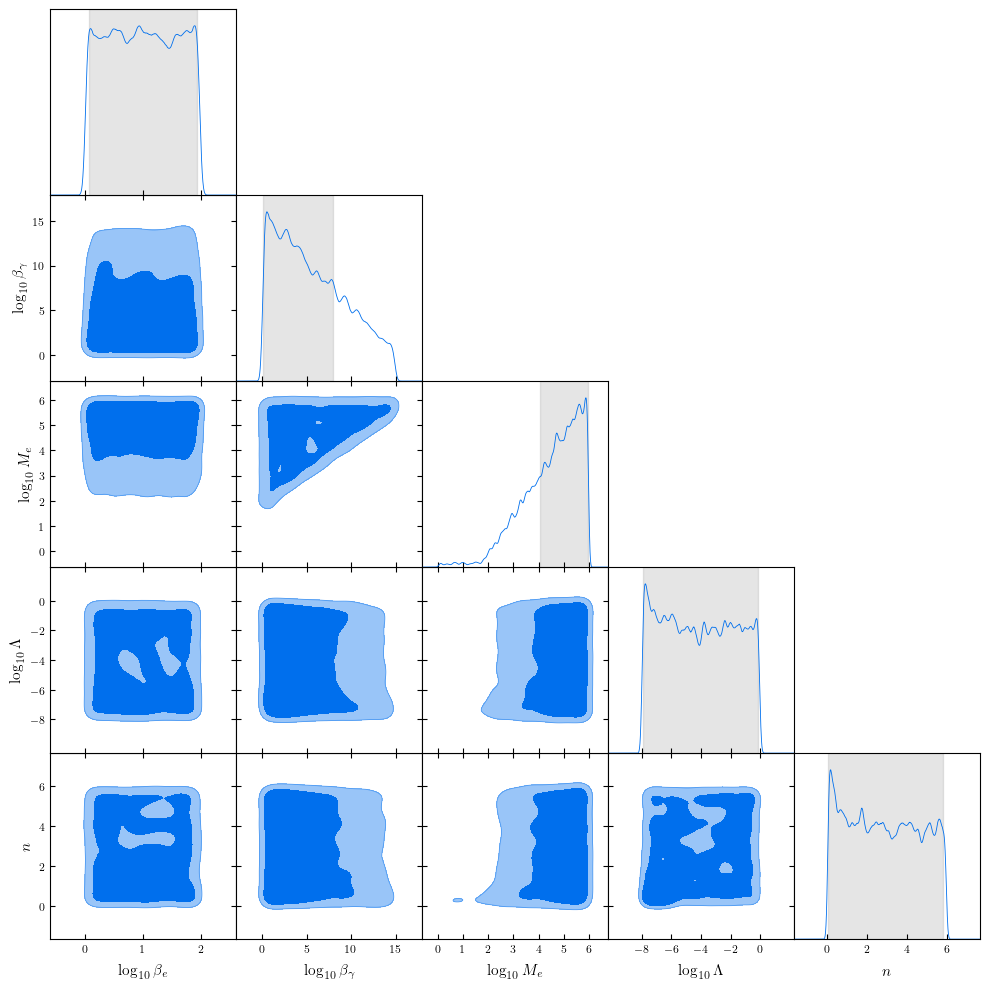

In [57]:
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

param_labels = ['ge', 'gg', 'logMe', 'gc', 'n']
latex_labels = [r'$\log_{10} \beta_e$', r'$\log_{10} \beta_\gamma$', r'$\log_{10} M_e$', r'$\log_{10} \Lambda$', r'$n$']
gdsamples = MCSamples(samples=samples1, names=param_labels, labels=latex_labels,
                      settings={'ignore_rows': 0, 'smooth_scale': 0.8,
                                'smooth_method': 'gaussian', 'smooth_bins': 50})

g = plots.get_subplot_plotter()
g.triangle_plot(gdsamples, filled=True, contour_levels=[0.68, 0.95])
axes = g.subplots

ge_stats = gdsamples.get1DDensity('ge')
gg_stats = gdsamples.get1DDensity('gg')
logMe_stats = gdsamples.get1DDensity('logMe')
gc_stats = gdsamples.get1DDensity('gc')
n_stats = gdsamples.get1DDensity('n')

ge_ci_90 = ge_stats.getLimits(0.68)
gg_ci_90 = gg_stats.getLimits(0.68)
logMe_ci_90 = logMe_stats.getLimits(0.68)
gc_ci_90 = gc_stats.getLimits(0.68)
n_ci_90 = n_stats.getLimits(0.68)

# Plot vertical shaded regions for 90% CI
ax_ge = axes[0, 0]
ax_ge.axvspan(ge_ci_90[0], ge_ci_90[1], color='gray', alpha=0.2, label='90% CI')
ax_gg = axes[1, 1]
ax_gg.axvspan(gg_ci_90[0], gg_ci_90[1], color='gray', alpha=0.2, label='90% CI')
ax_logMe = axes[2, 2]
ax_logMe.axvspan(logMe_ci_90[0], logMe_ci_90[1], color='gray', alpha=0.2, label='90% CI')
ax_gc = axes[3, 3]
ax_gc.axvspan(gc_ci_90[0], gc_ci_90[1], color='gray', alpha=0.2, label='90% CI')
ax_n = axes[4, 4]
ax_n.axvspan(n_ci_90[0], n_ci_90[1], color='gray', alpha=0.2, label='90% CI')

plt.savefig("plots/cornor_5D.pdf", dpi=300)
plt.show()

logMe 90% CI: (2.8860114362866702, 6.007311541373159, False, False)
gg 90% CI: (-0.008088587590498797, 11.764999322371018, False, False)


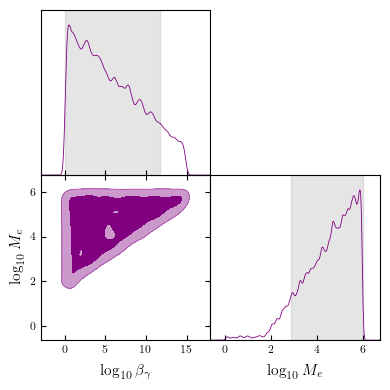

In [58]:
from getdist import MCSamples, plots
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Initialize GetDist plotter
g = plots.get_subplot_plotter()
g.triangle_plot(gdsamples, ['gg', 'logMe'], filled=True, contour_colors=['purple'],
                contour_levels=[0.68, 0.95])

axes = g.subplots

gg_stats = gdsamples.get1DDensity('gg')
logMe_stats = gdsamples.get1DDensity('logMe')

gg_ci_90 = gg_stats.getLimits(0.90)
logMe_ci_90 = logMe_stats.getLimits(0.90)

print("logMe 90% CI:", logMe_ci_90)
print("gg 90% CI:", gg_ci_90)

ax_gg = axes[0, 0]
ax_gg.axvspan(gg_ci_90[0], gg_ci_90[1], color='gray', alpha=0.2, label='90% CI')
ax_logMe = axes[1, 1]
ax_logMe.axvspan(logMe_ci_90[0], logMe_ci_90[1], color='gray', alpha=0.2, label='90% CI')

plt.savefig("plots/cornor_2D.pdf", dpi=300)
plt.show()